# I. Base Line Modeling

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
url =  'https://raw.githubusercontent.com/Calcious98/TIL/master/Chicago_Pothole_Weather_2011_2018(!%2B).csv'

df = pd.read_csv(url)

In [ ]:
df['tempmin^2'] = df['tempmin'] **2

df['evap'] = df['solarenergy'] * df['temp'] * df['humidity']

In [ ]:
X = df[['year', 'month', 'holiday', 'temp', 'tempmax', 'humidity', 'snowdepth','dew', 'windspeed', 'tempmin^2', 'evap']]

In [ ]:
from sklearn.model_selection import train_test_split


y = df['pothole']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (2045, 11) (2045,)
Test Data :  (877, 11) (877,)


## 1.Multivariate Regression

In [ ]:
%%time

from sklearn.linear_model import LinearRegression

MR = LinearRegression(normalize = True,
                      n_jobs = -1)

MR.fit(X_train, y_train)

CPU times: user 4.17 ms, sys: 49 µs, total: 4.22 ms
Wall time: 4.69 ms


LinearRegression(n_jobs=-1, normalize=True)

In [ ]:
# MSE, RMSE, R-Squared
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_hat = MR.predict(X_test)

Multi_mse = mean_squared_error(y_test, y_hat)
Multi_rmse = np.sqrt(mse)
Multi_r2_squared = r2_score(y_test, y_hat)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('r2_score : {0:.3f}'.format(r2_squared))

MSE : 5277.348, RMSE : 72.645
r2_score : 0.527


## 2.Decision Tree Regression

In [ ]:
%%time

from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor(criterion ='mse',
                            random_state = 2045)

DTR.fit(X_train, y_train)

CPU times: user 18.1 ms, sys: 0 ns, total: 18.1 ms
Wall time: 19.1 ms


DecisionTreeRegressor(criterion='mse', random_state=2045)

In [ ]:
dtree = mean_squared_error(y_test, DTR.predict(X_test))
rdtree = np.sqrt(dtree)
dscore = DTR.score(X_test, y_test)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(dtree, rdtree))
print('r2_score : {0:.3f}'.format(dscore))

MSE : 5120.379, RMSE : 71.557
r2_score : 0.541


### Feature Importance

In [ ]:
DTR.feature_importances_

array([0.08021327, 0.37455099, 0.2828511 , 0.02905475, 0.04506403,
       0.03030339, 0.03270802, 0.02548201, 0.02854733, 0.04258227,
       0.02864285])

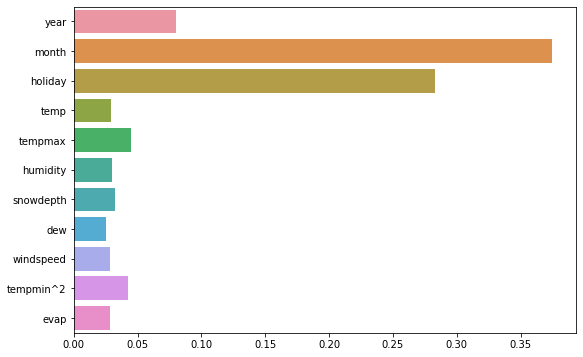

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (9, 6))
sns.barplot(DTR.feature_importances_,
            ['year', 'month', 'holiday', 'temp', 'tempmax', 'humidity', 'snowdepth','dew', 'windspeed', 'tempmin^2', 'evap'])
plt.show()

## 3.모델 비교

In [ ]:
import pandas as pd

MSE = [mse, dtree]

df = pd.DataFrame({'Regression' : ['Multivariate', 'Decision Tree'],
                   'MSE' : MSE,
                   'rMSE' : [np.sqrt(mse) for mse in MSE],
                   'R-score' : [mse,dscore]})

df.sort_values(by=['R-score'])

,Regression,MSE,rMSE,R-score
1,Decision Tree,5120.378563,71.556821,0.541062
0,Multivariate,5277.348435,72.645361,5277.348435


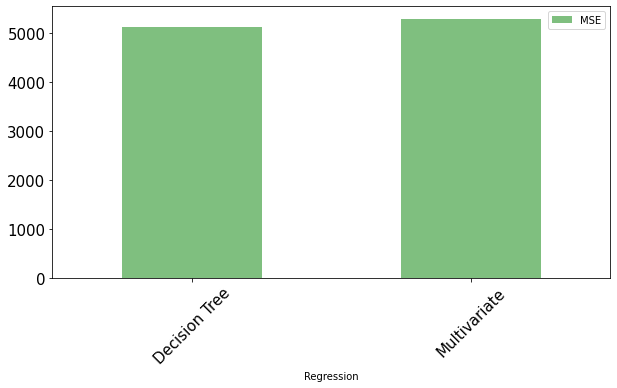

In [ ]:
df = df.sort_values(by=['MSE'], ascending=True)
df.plot.bar(x='Regression',y='MSE', rot=45, fontsize=15, figsize=(10,5), color='G', alpha=0.5)

# II. Modeling

In [ ]:
# import 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn model import 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
url = 'https://raw.githubusercontent.com/Calcious98/TIL/master/Chicago_Pothole_Weather_2011_2018(!%2B).csv'

df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        2922 non-null   object 
 1   year            2922 non-null   int64  
 2   month           2922 non-null   int64  
 3   day             2922 non-null   int64  
 4   holiday         2922 non-null   int64  
 5   temp            2922 non-null   float64
 6   tempmax         2922 non-null   float64
 7   tempmin         2922 non-null   float64
 8   humidity        2922 non-null   float64
 9   precip          2922 non-null   float64
 10  snowdepth       2922 non-null   float64
 11  solarenergy     2922 non-null   float64
 12  weather         2922 non-null   int64  
 13  dew             2922 non-null   float64
 14  precipcover     2922 non-null   float64
 15  windspeed       2922 non-null   float64
 16  solarradiation  2922 non-null   float64
 17  pothole         2922 non-null   i

파생변수 정의

In [ ]:
# 제곱을 해줘서 더욱더 미세한 차이를 모델이 학습을 통해 잡아낼 수 있도록 한다
df['tempmin^2'] = df['tempmin'] **2

# 증발정도(evaporation) 변수 생성 = 일조량 * 온도 * 습도
df['evap'] = df['solarenergy'] * df['temp'] * df['humidity']

# 1.Data Preprocessing

##1) Data Set

In [ ]:
X = df[['year', 'month', 'holiday', 'temp', 'tempmax', 'snowdepth','dew', 'windspeed', 'tempmin^2', 'evap']]
y = df['pothole']

##2) Train & Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (2045, 10) (2045,)
Test Data :  (877, 10) (877,)


##3) Polynomial degree = 1

In [ ]:
poly = PolynomialFeatures(degree = 1, include_bias = False)
PX_TR = poly.fit_transform(X_train)
PX_test = poly.fit_transform(X_test)

# 2.Model

##1) Random Forest Regression
- 훈련 과정에서 구성한 다수의 결정 트리로부터 평균 예측치를 출력함으로써 동작하는 앙상블형 모델

GridSearchCV 통해 하이퍼파라메터 조정  
- n_estimators : 모델에 사용되는 의사결정나무의 개수  
- max_features : 분할에 사용되는 Feature의 개수  
- max_depth : 트리모델의 최대 깊이를 지정

In [ ]:
%time 

RFR = RandomForestRegressor()

params = {'n_estimators':[600, 800, 1000, 1200, 1400],
          'max_features':[5, 10, 15, 20, 25],
          'max_depth':[5, 10, 15, 20, 25],
          'random_state':[2045]}

from sklearn.model_selection import GridSearchCV, KFold

grid_cv = GridSearchCV(RFR,
                       param_grid = params,
                       #scoring = 'neg_mean_squared_error',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(PX_TR, y_train)

print(grid_cv.best_params_)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.53 µs
{'max_depth': 25, 'max_features': 10, 'n_estimators': 1000, 'random_state': 2045}


하이퍼파라메터 튜닝 초기 score

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators = 1400,
                            max_features = 10,
                            max_depth = 25,
                            #criterion ='mse',
                            n_jobs = -1,
                            random_state = 2045)

RFR.fit(PX_TR, y_train)

print('OK')

from sklearn.metrics import mean_squared_error

PX_test = poly.fit_transform(X_test)

y_hat = RFR.predict(PX_test)

print('MSE: ', mean_squared_error(y_test, y_hat))
print('rMSE: ', np.sqrt(mean_squared_error(y_test, y_hat)))
#print('rMSE (Log 복원): ' , np.expm1(np.sqrt(mean_squared_error(y_test, y_hat))))

X_test_poly = poly.fit_transform(X_test)
print('R-Sqaure: ', RFR.score(X_test_poly, y_test))
print('adjusted R-squared: ', 1 - (1-RFR.score(X_test_poly, y_test))*(len(y_test)-1)/(len(y_test)-X_test_poly.shape[1]-1) )

OK
MSE:  2951.92115348305
rMSE:  54.33158522887999
R-Sqaure:  0.7354204671526099
adjusted R-squared:  0.732365276242132


In [ ]:
%time 

RFR = RandomForestRegressor()

params = {'n_estimators':[1400, 1500, 1600, 1700, 1800],
          'max_features':[10],
          'max_depth':[25, 30, 35, 40, 45],
          'random_state':[2045]}

from sklearn.model_selection import GridSearchCV, KFold

grid_cv = GridSearchCV(RFR,
                       param_grid = params,
                       #scoring = 'neg_mean_squared_error',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(PX_TR, y_train)

print(grid_cv.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
{'max_depth': 25, 'max_features': 10, 'n_estimators': 1400, 'random_state': 2045}


In [ ]:
%time 

RFR = RandomForestRegressor()

params = {'n_estimators':[1800, 2000, 2200, 2400, 2600],
          'max_features':[10],
          'max_depth':[25],
          'random_state':[2045]}

from sklearn.model_selection import GridSearchCV, KFold

grid_cv = GridSearchCV(RFR,
                       param_grid = params,
                       #scoring = 'neg_mean_squared_error',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(PX_TR, y_train)

print(grid_cv.best_params_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
{'max_depth': 25, 'max_features': 10, 'n_estimators': 2200, 'random_state': 2045}


In [ ]:
%time 

RFR = RandomForestRegressor()

params = {'n_estimators':[2600, 2800, 3000, 3200, 3400],
          'max_features':[10],
          'max_depth':[25],
          'random_state':[2045]}

from sklearn.model_selection import GridSearchCV, KFold

grid_cv = GridSearchCV(RFR,
                       param_grid = params,
                       #scoring = 'neg_mean_squared_error',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(PX_TR, y_train)

print(grid_cv.best_params_)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.01 µs
{'max_depth': 25, 'max_features': 10, 'n_estimators': 3000, 'random_state': 2045}


하이퍼파라메터 조정된 최종 score
- n_estimators = 3000 / max_features = 10 / max_depth = 25

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators = 3000,
                            max_features = 10,
                            max_depth = 25,
                            #criterion ='mse',
                            n_jobs = -1,
                            random_state = 2045)

RFR.fit(PX_TR, y_train)

print('OK')

from sklearn.metrics import mean_squared_error

PX_test = poly.fit_transform(X_test)

y_hat = RFR.predict(PX_test)

print('MSE: ', mean_squared_error(y_test, y_hat))
print('rMSE: ', np.sqrt(mean_squared_error(y_test, y_hat)))
#print('rMSE (Log 복원): ' , np.expm1(np.sqrt(mean_squared_error(y_test, y_hat))))

X_test_poly = poly.fit_transform(X_test)
print('R-Sqaure: ', RFR.score(X_test_poly, y_test))
print('adjusted R-squared: ', 1 - (1-RFR.score(X_test_poly, y_test))*(len(y_test)-1)/(len(y_test)-X_test_poly.shape[1]-1) )

OK
MSE:  2950.228476476654
rMSE:  54.31600571172971
R-Sqaure:  0.7355721811274514
adjusted R-squared:  0.7325187421104473


### 값

In [ ]:
y_hat = RFR.predict(X_test)
RFR_MSE = mean_squared_error(y_test, y_hat)
RFR_rMSE = np.sqrt(mean_squared_error(y_test, y_hat))
RFR_Rscore =  RFR.score(X_test_poly, y_test)
print(RFR_MSE, RFR_rMSE, RFR_Rscore)

2950.228476476654 54.31600571172971 0.7355721811274514


##2) GBM(Gradient Boosting Machine) Regressor
- 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 생성

하이퍼파라메터 미조정 score

In [ ]:
%%time

GBR = GradientBoostingRegressor(loss = 'ls',
                                #n_estimators = 9000,
                                #learning_rate = 0.0001,
                                criterion ='mse',
                                #max_features = 3,
                                #max_depth = 1,
                                random_state = 2045)

GBR.fit(X_train, y_train)
y_hat = GBR.predict(X_test)

CPU times: user 306 ms, sys: 616 µs, total: 307 ms
Wall time: 307 ms


In [ ]:
# MSE, RMSE, R-Squared

y_preds = y_hat
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
r2_squared = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('R-Sqaured : {0:.3f}'.format(r2_squared))

MSE : 3143.214, RMSE : 56.064
R-Sqaured : 0.718


GridSearchCV 통해 하이퍼파라메터 조정
- loss : Optimization Method / 
'ls' : Least Squares Regression
- n_estimators : 생성되는 트리의 수
값이 크면 모델의 복잡도가 증가 / 
오차를 보정할 기회가 증가
- learning_rate : 이전 트리의 오차를 얼마나 강한게 보정할 것인지 제어 / 
값이 크면 강한 보정에 의해 복잡한 트리 생성

In [ ]:
%time 

GBR = GradientBoostingRegressor(loss = 'ls', 
                                criterion ='mse')


params = {'n_estimators' : [15000, 20000], 
          'learning_rate' : [0.0004, 0.0005], 
          'max_features' : [7, 9], 
          'max_depth' : [5, 7], 
          'random_state' : [2045]}

grid_cv = GridSearchCV(GBR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

하이퍼파라메터 조정된 최종 score
- n_estimators = 15000 / learning_rate = 0.0005 / random_state = 2045)

In [ ]:
%%time

GBR = GradientBoostingRegressor(loss = 'ls',
                                n_estimators = 15000,
                                learning_rate = 0.0005,
                                criterion ='mse',
                                max_features = 7,
                                max_depth = 7,
                                random_state = 2045)

GBR.fit(X_train, y_train)
y_hat = GBR.predict(X_test)

CPU times: user 1min 10s, sys: 244 ms, total: 1min 10s
Wall time: 1min 11s


In [ ]:
# MSE, RMSE, R-Squared

y_preds = y_hat
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
r2_squared = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('R-Sqaured : {0:.3f}'.format(r2_squared))

MSE : 2899.984, RMSE : 53.851
R-Sqaured : 0.740


### 값

In [ ]:
y_hat = GBR.predict(X_test)
GBMR_MSE = mean_squared_error(y_test, y_hat)
GBMR_rMSE = np.sqrt(mean_squared_error(y_test, y_hat))
GBMR_Rscore =  GBR.score(X_test_poly, y_test)
print(GBMR_MSE, GBMR_rMSE, GBMR_Rscore)

2899.9837062582 53.851496787537855 0.7400756001353532


In [ ]:
%time 

GBR = GradientBoostingRegressor(loss = 'ls', 
                                criterion ='mse')


params = {'n_estimators' : [15000, 20000], 
          'learning_rate' : [0.0004, 0.0005], 
          'max_features' : [7, 9], 
          'max_depth' : [5, 7], 
          'random_state' : [2045]}

grid_cv = GridSearchCV(GBR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
{'learning_rate': 0.0005, 'max_depth': 5, 'max_features': 7, 'n_estimators': 20000, 'random_state': 2045}


In [ ]:
%%time

GBR = GradientBoostingRegressor(loss = 'ls',
                                n_estimators = 15000,
                                learning_rate = 0.0005,
                                criterion ='mse',
                                max_features = 7,
                                max_depth = 7,
                                random_state = 2045)

GBR.fit(X_train, y_train)
y_hat = GBR.predict(X_test)

CPU times: user 1min 15s, sys: 233 ms, total: 1min 15s
Wall time: 1min 16s


하이퍼파라메터 조정된 최종 score
- n_estimators = 15000 / learning_rate = 0.0005 / random_state = 2045)

In [ ]:
# MSE, RMSE, R-Squared

y_preds = y_hat
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
r2_squared = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('R-Sqaured : {0:.3f}'.format(r2_squared))

MSE : 2899.984, RMSE : 53.851
R-Sqaured : 0.740


##3) Adaptive Boosting Regressor
- 이전 트리가 잘못 예측한 샘플에 가중치를 높여서 다음 트리를 훈련
- 훈련된 모델은 성능에 따라 가중치가 부여

하이퍼파라메터 미조정 score

In [ ]:
%%time

ABR = AdaBoostRegressor(#loss = 'square',
                        #n_estimators = 500,
                        #learning_rate = 0.0001,
                        random_state = 2045)

ABR.fit(X_train, y_train)
y_hat = ABR.predict(X_test)

CPU times: user 104 ms, sys: 956 µs, total: 105 ms
Wall time: 105 ms


In [ ]:
# MSE, RMSE, R-Squared

y_preds = y_hat
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
r2_squared = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('R-Sqaured : {0:.3f}'.format(r2_squared))

MSE : 5550.141, RMSE : 74.499
R-Sqaured : 0.503


GridSearchCV 통해 하이퍼파라메터 조정
- loss: Optimization Method
- n_estimators: 생성되는 트리의 수. 값이 크면 모델의 복잡도가 증가
- learning_rate: 이전 트리의 오차를 얼마나 강한게 보정할 것인지 제어



In [ ]:
%time 
ABR = AdaBoostRegressor()

params = {'n_estimators':[500, 700, 900, 1100],
          'learning_rate' :[0.0001, 0.0002, 0.0003],
          'random_state':[2045]}

grid_cv = GridSearchCV(ABR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs
{'learning_rate': 0.0002, 'n_estimators': 500, 'random_state': 2045}


In [ ]:
%time 
ABR = AdaBoostRegressor()

params = {'n_estimators':[500, 700, 900, 1100],
          'learning_rate' :[0.0005, 0.0007, 0.0009],
          'random_state':[2045]}

grid_cv = GridSearchCV(ABR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
{'learning_rate': 0.0005, 'n_estimators': 500, 'random_state': 2045}


In [ ]:
%time 
ABR = AdaBoostRegressor()

params = {'n_estimators':[1300, 1500, 3000],
          'learning_rate' :[0.0005, 0.0007, 0.0009],
          'random_state':[2045]}

grid_cv = GridSearchCV(ABR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
{'learning_rate': 0.0005, 'n_estimators': 1300, 'random_state': 2045}


In [ ]:
%time 
ABR = AdaBoostRegressor()

params = {'n_estimators':[100, 200, 300, 400],
          'learning_rate' :[0.0003, 0.0005, 0.0007, 0.0009],
          'random_state':[2045]}

grid_cv = GridSearchCV(ABR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
{'learning_rate': 0.0007, 'n_estimators': 200, 'random_state': 2045}


In [ ]:
%time 
ABR = AdaBoostRegressor(loss = 'square')

params = {'n_estimators':[700, 900, 1100, 2000],
          'learning_rate' :[0.0009, 0.001, 0.0006],
          'random_state':[2045]}

grid_cv = GridSearchCV(ABR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
{'learning_rate': 0.0006, 'n_estimators': 700, 'random_state': 2045}


In [ ]:
%time 
ABR = AdaBoostRegressor(loss = 'square')

params = {'n_estimators':[600, 800, 1000, 1200],
          'learning_rate' :[0.0004, 0.0006, 0.0008],
          'random_state':[2045]}

grid_cv = GridSearchCV(ABR,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs
{'learning_rate': 0.0006, 'n_estimators': 600, 'random_state': 2045}


하이퍼파라메터 조정된 최종 score
- 'learning_rate': 0.0006 / 'n_estimators': 600 / 'random_state': 2045

In [ ]:
%%time

ABR = AdaBoostRegressor(loss = 'square',
                        n_estimators = 600,
                        learning_rate = 0.0006,
                        random_state = 2045)

ABR.fit(X_train, y_train)
y_hat = ABR.predict(X_test)

CPU times: user 2.45 s, sys: 20 ms, total: 2.47 s
Wall time: 2.46 s


In [ ]:
# MSE, RMSE, R-Squared

y_preds = y_hat
mse = mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
r2_squared = r2_score(y_test, y_preds)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('R-Sqaured : {0:.3f}'.format(r2_squared))

MSE : 4199.570, RMSE : 64.804
R-Sqaured : 0.624


### 값

In [ ]:
y_hat = ABR.predict(X_test)
ABR_MSE = mean_squared_error(y_test, y_hat)
ABR_rMSE = np.sqrt(mean_squared_error(y_test, y_hat))
ABR_Rscore =  ABR.score(X_test_poly, y_test)
print(ABR_MSE, ABR_rMSE, ABR_Rscore)

4199.569717081522 64.80408719426208 0.623594216737654


##4) XGBoost Regression

하이퍼파라메터 미조정 score

In [ ]:
%%time

from xgboost import XGBRegressor

XGB = XGBRegressor(booster = 'gblinear',
                   n_estimators = 1000,
                   learning_rate = 0.8,
                   reg_lambda = 2.0,
                   n_jobs = -1,
                   random_state = 2045)

XGB.fit(X_train, y_train)

[10:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 192 ms, sys: 969 µs, total: 193 ms
Wall time: 110 ms


XGBRegressor(n_jobs=-1, random_state=2045)

In [ ]:
xgb = mean_squared_error(y_test, XGB.predict(X_test))
xgb

7693.419665003758

In [ ]:
xscore = XGB.score(X_test, y_test)
xscore

0.3104418190289896

GridSearchCV 통해 하이퍼파라메터 조정  
- n_estimators : 모델에 사용되는 의사결정나무의 개수  
- learning_rate: 이전 트리의 오차를 얼마나 강한게 보정할 것인지 제어


In [ ]:
%time 

from xgboost import XGBRegressor

XGB = XGBRegressor(booster = 'gblinear', n_jobs = -1, reg_lambda = 2.0,)

params = {'n_estimators':[100, 200, 300, 500],
          'learning_rate' :[0.2, 0.3, 0.5, 0.7, 0.8, 1.2, 1.5, 1.8, 2.5, 3.6],
          # 'max_features' : [5, 9, 11],
           'max_depth':[1, 2, 3, 4, 6, 8, 10],

          'random_state':[2045]}

grid_cv = GridSearchCV(XGB,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)
print(grid_cv.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
[11:15:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 1.8, 'max_depth': 1, 'n_estimators': 300, 'random_state': 2045}


In [ ]:
%time 

from xgboost import XGBRegressor

XGB = XGBRegressor(booster = 'gblinear', n_jobs = -1, reg_lambda = 2.0,)

params = {'n_estimators':[200, 250, 300, 350, 400],
          'learning_rate' :[1.6, 1.7, 1.8, 1.9, 2.0],
          # 'max_features' : [5, 9, 11],
           'max_depth':[1],

          'random_state':[2045]}

grid_cv = GridSearchCV(XGB,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)
print(grid_cv.best_params_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
[11:18:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 1.8, 'max_depth': 1, 'n_estimators': 300, 'random_state': 2045}


하이퍼파라메터 조정된 최종 score
- 'learning_rate': 1.8 / 'n_estimators': 300 / 'max_depth': 1

In [ ]:
%%time

from xgboost import XGBRegressor

XGB = XGBRegressor(n_estimators = 300,
                   learning_rate = 1.8,
                   reg_lambda = 2.0,
                   n_jobs = -1,
                   max_depth = 1,
                   random_state = 2045)

XGB.fit(X_train, y_train)

[11:34:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 243 ms, sys: 1.9 ms, total: 245 ms
Wall time: 129 ms


XGBRegressor(learning_rate=1.8, max_depth=1, n_estimators=300, n_jobs=-1,
             random_state=2045, reg_lambda=2.0)

In [ ]:
y_hat = XGB.predict(X_test)

print('MSE: ', mean_squared_error(y_test, y_hat))
print('rMSE: ', np.sqrt(mean_squared_error(y_test, y_hat)))
print('R-Sqaure: ', XGB.score(X_test, y_test))

MSE:  5205.576887490045
rMSE:  72.14968390429749
R-Sqaure:  0.5334261894264394


### 값

In [ ]:
y_hat = XGB.predict(X_test)
XGBR_MSE = mean_squared_error(y_test, y_hat)
XGBR_rMSE = np.sqrt(mean_squared_error(y_test, y_hat))
XGBR_Rscore =  XGB.score(X_test, y_test)
print(XGBR_MSE, XGBR_rMSE, XGBR_Rscore)

5205.576887490045 72.14968390429749 0.5334261894264394


##5) LightGBM Regression

GridSearchCV 통해 하이퍼파라메터 조정
- n_estimators: 생성되는 트리의 수. 값이 크면 모델의 복잡도가 증가
- learning_rate: 이전 트리의 오차를 얼마나 강한게 보정할 것인지 제어
- max_depth: 트리모델의 최대 깊이를 지정

하이퍼파라메터 미조정 score

In [ ]:
%%time

from lightgbm import LGBMRegressor

LGB = LGBMRegressor(linear_tree = True,
                    boosting_type = 'gbdt',
                    objective = 'regression',
                    n_estimators = 100,
                    learning_rate = 0.01,
                    max_depth = 10,
                    n_jobs = -1)

LGB.fit(X_train, y_train)
lgbm = mean_squared_error(y_test, LGB.predict(X_test))
Rlgbm = np.sqrt(mean_squared_error(y_test, LGB.predict(X_test)))
R2_lgbm = LGB.score(X_test, y_test)

print('MSE : {0:.3f}, Rmse : {1:.3f}'. format(lgbm,Rlgbm))
print('r2 score : {0:.3f}'.format(R2_lgbm))

MSE : 4295.089, Rmse : 65.537
r2 score : 0.615
CPU times: user 359 ms, sys: 9.05 ms, total: 368 ms
Wall time: 256 ms


In [ ]:
%time 

from lightgbm import LGBMRegressor

LGB = LGBMRegressor(linear_tree = True,
                    boosting_type = 'gbdt',
                    objective = 'regression')

params = {'n_estimators':[300,400,500,600,700,800],
          'learning_rate' :[0.001, 0.002, 0.003],
          'max_depth':[1,2,3,4,5]}

grid_cv = GridSearchCV(LGB,
                       param_grid = params,
                       #scoring = 'accuracy',
                       #cv = KFold(n_splits = 5),
                       refit = True,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs
{'learning_rate': 0.003, 'max_depth': 5, 'n_estimators': 800}


하이퍼파라메터 조정된 최종 score
- n_estimators: 1600 / 
learning_rate: 0.006 / 
max_depth: 7

In [ ]:
%%time

from lightgbm import LGBMRegressor

LGB = LGBMRegressor(linear_tree = True,
                    boosting_type = 'gbdt',
                    objective = 'regression',
                    n_estimators = 1600,
                    learning_rate = 0.006,
                    max_depth = 7,
                    n_jobs = -1)

LGB.fit(X_train, y_train)

CPU times: user 2.28 s, sys: 133 ms, total: 2.41 s
Wall time: 1.26 s


LGBMRegressor(learning_rate=0.006, linear_tree=True, max_depth=7,
              n_estimators=1600, objective='regression')

In [ ]:
lgbm = mean_squared_error(y_test, LGB.predict(X_test))
Rlgbm = np.sqrt(mean_squared_error(y_test, LGB.predict(X_test)))
R2_lgbm = LGB.score(X_test, y_test)

print('MSE : {0:.3f}, Rmse : {1:.3f}'. format(lgbm,Rlgbm))
print('r2 score : {0:.3f}'.format(R2_lgbm))

MSE : 2933.239, Rmse : 54.159
r2 score : 0.737


### 값

In [ ]:
y_hat = LGB.predict(X_test)
LGBMR_MSE = mean_squared_error(y_test, y_hat)
LGBMR_rMSE = np.sqrt(mean_squared_error(y_test, y_hat))
LGBMR_Rscore =  LGB.score(X_test_poly, y_test)
print(LGBMR_MSE, LGBMR_rMSE, LGBMR_Rscore)

2933.2386174818953 54.15938162019481 0.7370949755119398


# 3.모델 비교

In [ ]:
import pandas as pd


# dtree = mean_squared_error(y_test, DTR.predict(X_test))
# rdtree = np.sqrt(dtree)
# dscore = DTR.score(X_test, y_test)

# Multi_mse = mean_squared_error(y_test, y_hat)
# Multi_rmse = np.sqrt(mse)
# Multi_r2_squared = r2_score(y_test, y_hat)


df = pd.DataFrame({'Regression' : ['Multivariate', 'Decision Tree','Random Forest','GBM','AdaBoosting','XGBoost','LightGBM'],
                   'MSE' : [Multi_mse, dtree, RFR_MSE, GBMR_MSE, ABR_MSE, XGBR_MSE, LGBMR_MSE],
                   'rMSE' : [Multi_rmse, rdtree, RFR_rMSE, GBMR_rMSE, ABR_rMSE, XGBR_rMSE, LGBMR_rMSE],
                   'R-score' : [Multi_r2_squared, dscore, RFR_Rscore, GBMR_Rscore, ABR_Rscore, XGBR_Rscore, LGBMR_Rscore]})

df.sort_values(by=['R-score'], ascending=False)

,Regression,MSE,rMSE,R-score
3,GBM,2899.983706,53.851497,0.740076
6,LightGBM,2933.238617,54.159382,0.737095
2,Random Forest,2950.228476,54.316006,0.735572
4,AdaBoosting,4199.569717,64.804087,0.623594
1,Decision Tree,5120.378563,71.556821,0.541062
5,XGBoost,5205.576887,72.149684,0.533426
0,Multivariate,5277.348435,72.645361,0.526993


Text(0.5, 0, ' ')

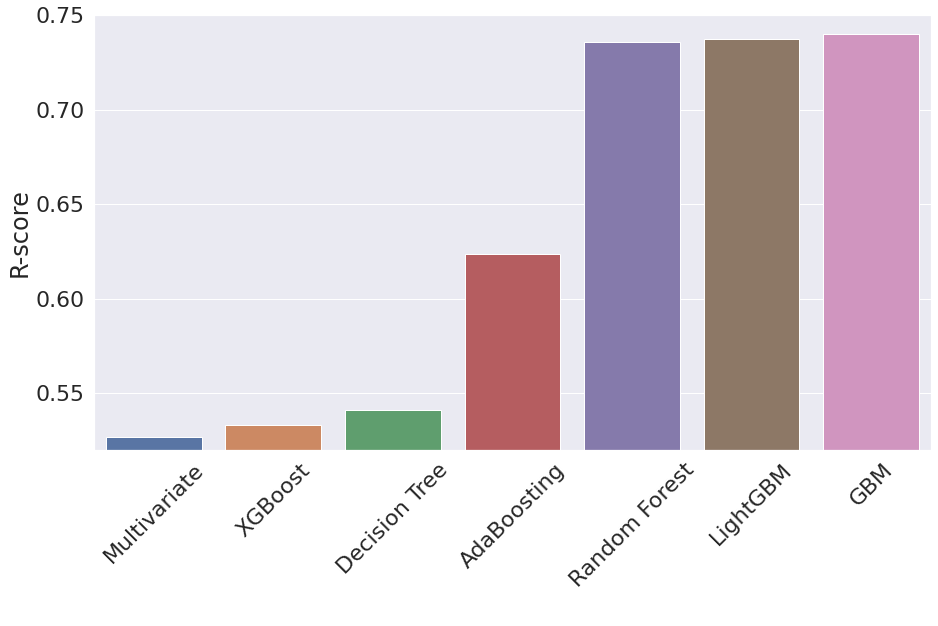

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df.sort_values(by=['R-score'], ascending=True)

# df.plot.bar(x='Regression',y='R-score', rot=45, fontsize=15, figsize=(10,5), color='G', alpha=0.5)
df_by_group = df.groupby(['R-score'])['Regression'].sum().reset_index()
sns.barplot(x='Regression', y='R-score', data=df_by_group)
plt.ylim([0.52, 0.75]) 

parameters = {'axes.labelsize': 10,
          'axes.titlesize': 10}
plt.rcParams.update(parameters)
sns.set(font_scale=2)
plt.xticks(rotation= 45)
plt.xlabel(' ')